# Prepare Environment
```
conda create --name hydranet pytorch torchvision torchaudio pytorch-cuda -c pytorch -c nvidia
conda activate hydranet
pip install opencv-python matplotlib ipykernel tqdm notebook
```

# Import Libraries
These are all the libraries you'll need throughout the notebook. The next several sections have code similar to the previous modules in this course in order to define a consistent model architecture for the transfer learning exercise. 

In [39]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from PIL import Image
import glob
from utils import Normalise, RandomCrop, ToTensor, RandomMirror, InvHuberLoss, AverageMeter, MeanIoU, RMSE
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from model_helpers import Saver, load_state_dict
import operator
import torch.nn.functional as F
from tqdm import tqdm
from torch.autograd import Variable
import cv2

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as co
from IPython.display import HTML
from base64 import b64encode
from IPython.display import Video

# Create Dataset
Setup the PyTorch classes to handle the NYU Depth Dataset.

In [40]:
img_scale = 1.0 / 255
depth_scale = 5000.0

img_mean = np.array([0.485, 0.456, 0.406])
img_std = np.array([0.229, 0.224, 0.225])

normalise_params = [img_scale, img_mean.reshape((1, 1, 3)), img_std.reshape((1, 1, 3)), depth_scale,]

transform_common = [Normalise(*normalise_params), ToTensor()]

crop_size = 400
transform_train = transforms.Compose([RandomMirror(), RandomCrop(crop_size)] + transform_common)
transform_val = transforms.Compose(transform_common)

train_batch_size = 4
val_batch_size = 4
train_file = "train_list_depth.txt"
val_file = "val_list_depth.txt"

depth = sorted(glob.glob("nyud/depth/*.png"))
seg = sorted(glob.glob("nyud/masks/*.png"))
images = sorted(glob.glob("nyud/rgb/*.png"))

class HydranetDataset(Dataset):

    def __init__(self, data_file, transform=None):
        with open(data_file, "rb") as f:
            datalist = f.readlines()
        self.datalist = [x.decode("utf-8").strip("\n").split("\t") for x in datalist]
        self.root_dir = "nyud"
        self.transform = transform
        self.masks_names = ("segm", "depth")

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        abs_paths = [os.path.join(self.root_dir, rpath) for rpath in self.datalist[idx]] # Will output list of nyud/*/00000.png
        sample = {}
        sample["image"] = np.array(Image.open(abs_paths[0])) #dtype = np.float32

        for mask_name, mask_path in zip(self.masks_names, abs_paths[1:]):
            mask = np.array(Image.open(mask_path))
            assert len(mask.shape) == 2, "Masks must be encoded without colourmap"
            sample[mask_name] = mask

        if self.transform:
            sample["names"] = self.masks_names
            sample = self.transform(sample)
            # the names key can be removed by the transformation
            if "names" in sample:
                del sample["names"]
        return sample
    
#TRAIN DATALOADER
trainloader = DataLoader(
    HydranetDataset(train_file, transform=transform_train,),
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)

# VALIDATION DATALOADER
valloader = DataLoader(
    HydranetDataset(val_file, transform=transform_val,),
    batch_size=val_batch_size, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True,
    drop_last=False,)

# Encoder
Define all the necessary layers for MobileNet, load the pre-trained weights and freeze them to speed up training.

In [41]:
def conv1x1(in_channels, out_channels, stride=1, groups=1, bias=False,):
    "1x1 Convolution: Pointwise"
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=bias, groups=groups)

def conv3x3(in_channels, out_channels, stride=1, dilation=1, groups=1, bias=False):
    """3x3 Convolution: Depthwise: 
    https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    """
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=bias, groups=groups)

def batchnorm(num_features):
    """
    https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
    """
    return nn.BatchNorm2d(num_features, affine=True, eps=1e-5, momentum=0.1)

def convbnrelu(in_channels, out_channels, kernel_size, stride=1, groups=1, act=True):
    "conv-batchnorm-relu"
    if act:
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=int(kernel_size / 2.), groups=groups, bias=False),
                             batchnorm(out_channels),
                             nn.ReLU6(inplace=True))
    else:
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=int(kernel_size / 2.), groups=groups, bias=False),
                             batchnorm(out_channels))

class InvertedResidualBlock(nn.Module):
    """Inverted Residual Block from https://arxiv.org/abs/1801.04381"""
    def __init__(self, in_planes, out_planes, expansion_factor, stride=1):
        super().__init__() # Python 3
        intermed_planes = in_planes * expansion_factor
        self.residual = (in_planes == out_planes) and (stride == 1) # Boolean/Condition
        self.output = nn.Sequential(convbnrelu(in_planes, intermed_planes, 1),
                                    convbnrelu(intermed_planes, intermed_planes, 3, stride=stride, groups=intermed_planes),
                                    convbnrelu(intermed_planes, out_planes, 1, act=False))

    def forward(self, x):
        #residual = x
        out = self.output(x)
        if self.residual:
            return (out + x)#+residual
        else:
            return out

class MobileNetv2(nn.Module):
    def __init__(self, return_idx=[6]):
        super().__init__()
        # expansion rate, output channels, number of repeats, stride
        self.mobilenet_config = [
        [1, 16, 1, 1],
        [6, 24, 2, 2],
        [6, 32, 3, 2],
        [6, 64, 4, 2],
        [6, 96, 3, 1],
        [6, 160, 3, 2],
        [6, 320, 1, 1],
        ]
        self.in_channels = 32  # number of input channels
        self.num_layers = len(self.mobilenet_config)
        self.layer1 = convbnrelu(3, self.in_channels, kernel_size=3, stride=2)
    
        self.return_idx = [1, 2, 3, 4, 5, 6]
        #self.return_idx = make_list(return_idx)

        c_layer = 2
        for t, c, n, s in self.mobilenet_config:
            layers = []
            for idx in range(n):
                layers.append(InvertedResidualBlock(self.in_channels,c,expansion_factor=t,stride=s if idx == 0 else 1,))
                self.in_channels = c
            setattr(self, "layer{}".format(c_layer), nn.Sequential(*layers))
            c_layer += 1

        self._out_c = [self.mobilenet_config[idx][1] for idx in self.return_idx] # Output: [24, 32, 64, 96, 160, 320]

    def forward(self, x):
        outs = []
        x = self.layer1(x)
        outs.append(self.layer2(x))  # 16, x / 2
        outs.append(self.layer3(outs[-1]))  # 24, x / 4
        outs.append(self.layer4(outs[-1]))  # 32, x / 8
        outs.append(self.layer5(outs[-1]))  # 64, x / 16
        outs.append(self.layer6(outs[-1]))  # 96, x / 16
        outs.append(self.layer7(outs[-1]))  # 160, x / 32
        outs.append(self.layer8(outs[-1]))  # 320, x / 32
        return [outs[idx] for idx in self.return_idx]
    
encoder = MobileNetv2()
encoder.load_state_dict(torch.load("mobilenetv2-e6e8dd43.pth"))

# Freeze the MobileNet weights
for param in encoder.parameters():
    param.requires_grad = False

# Decoder
Create the decoder and initial model. Most things here are the same as the previous code but notice the parameter *return_backbone* has been added when constructing MTLWRefineNet. Later this will be used to get the outputs from the backbone which will be needed to train a new head, you can see how this is done in the forward method.

In [42]:
def make_list(x):
    """Returns the given input as a list."""
    if isinstance(x, list):
        return x
    elif isinstance(x, tuple):
        return list(x)
    else:
        return [x]
    
class CRPBlock(nn.Module):
    """CRP definition"""
    def __init__(self, in_planes, out_planes, n_stages, groups=False):
        super().__init__()
        for i in range(n_stages):
            setattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'),
                    conv1x1(in_planes if (i == 0) else out_planes,
                            out_planes, stride=1,
                            bias=False, groups=in_planes if groups else 1))
        self.stride = 1
        self.n_stages = n_stages
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        top = x
        for i in range(self.n_stages):
            top = self.maxpool(top)
            top = getattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'))(top)
            x = top + x
        return x

class MTLWRefineNet(nn.Module):
    def __init__(self, input_sizes, num_classes, agg_size=256, n_crp=4, return_backbone=False):
        super().__init__()

        stem_convs = nn.ModuleList()
        crp_blocks = nn.ModuleList()
        adapt_convs = nn.ModuleList()
        heads = nn.ModuleList()

        # Reverse since we recover information from the end
        input_sizes = list(reversed((input_sizes)))

        # No reverse for collapse indices is needed
        self.collapse_ind = [[0, 1], [2, 3], 4, 5]

        groups = [False] * len(self.collapse_ind)
        groups[-1] = True

        for size in input_sizes:
            stem_convs.append(conv1x1(size, agg_size, bias=False))

        for group in groups:
            crp_blocks.append(self._make_crp(agg_size, agg_size, n_crp, group))
            adapt_convs.append(conv1x1(agg_size, agg_size, bias=False))

        self.stem_convs = stem_convs
        self.crp_blocks = crp_blocks
        self.adapt_convs = adapt_convs[:-1]

        num_classes = list(num_classes)
        for n_out in num_classes:
            heads.append(
                nn.Sequential(
                    conv1x1(agg_size, agg_size, groups=agg_size, bias=False),
                    nn.ReLU6(inplace=False),
                    conv3x3(agg_size, n_out, bias=True),
                )
            )

        self.heads = heads
        self.relu = nn.ReLU6(inplace=True)
        self.return_backbone = return_backbone

    def forward(self, xs):
        xs = list(reversed(xs))
        for idx, (conv, x) in enumerate(zip(self.stem_convs, xs)):
            xs[idx] = conv(x)

        # Collapse layers
        c_xs = [sum([xs[idx] for idx in make_list(c_idx)]) for c_idx in self.collapse_ind ]

        for idx, (crp, x) in enumerate(zip(self.crp_blocks, c_xs)):
            if idx == 0:
                y = self.relu(x)
            else:
                y = self.relu(x + y)
            y = crp(y)
            if idx < (len(c_xs) - 1):
                y = self.adapt_convs[idx](y)
                y = F.interpolate(
                    y,
                    size=c_xs[idx + 1].size()[2:],
                    mode="bilinear",
                    align_corners=True,
                )

        outs = []
        for head in self.heads:
            outs.append(head(y))

        if self.return_backbone:
            outs.append(y)
        
        return outs

    @staticmethod
    def _make_crp(in_planes, out_planes, stages, groups):
        # Same as previous, but showing the use of a @staticmethod
        layers = [CRPBlock(in_planes, out_planes, stages, groups)]
        return nn.Sequential(*layers)
        
        
num_classes = (40, 1)
decoder = MTLWRefineNet(encoder._out_c, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hydranet = nn.DataParallel(nn.Sequential(encoder, decoder)).to(device)
print("Model has {} parameters".format(sum([p.numel() for p in hydranet.parameters()])))

Model has 3070057 parameters


# Loss
Create the loss functions to train the depth and segmentation heads.

In [43]:
ignore_index = 255
ignore_depth = 0

crit_segm  = nn.CrossEntropyLoss(ignore_index=ignore_index)
crit_depth = InvHuberLoss(ignore_index=ignore_depth)

# Optimizers
Create the encoder and decoder optimizers.

In [44]:
lr_encoder = 1e-2
lr_decoder = 1e-3
momentum_encoder = 0.9
momentum_decoder = 0.9
weight_decay_encoder = 1e-5
weight_decay_decoder = 1e-5

optims = [torch.optim.SGD(encoder.parameters(), lr=lr_encoder, momentum=momentum_encoder, weight_decay=weight_decay_encoder),
          torch.optim.SGD(decoder.parameters(), lr=lr_decoder, momentum=momentum_decoder, weight_decay=weight_decay_decoder)]

# Train
Define the train and validate methods.

In [45]:
init_vals = (0.0, 10000.0)
comp_fns = [operator.gt, operator.lt]
ckpt_dir = "./base_model"
ckpt_path = "./base_model/checkpoint.pth.tar"

batch_size = 16
val_batch_size = 16
val_every = 5
loss_coeffs = (0.5, 0.5)
n_epochs = 500

saver = Saver(
    #args=locals(), # Causes issues in vscode
    args={"items": None},
    ckpt_dir=ckpt_dir,
    best_val=init_vals,
    condition=comp_fns,
    save_several_mode=all,
)

start_epoch, _, state_dict = saver.maybe_load(ckpt_path=ckpt_path, keys_to_load=["epoch", "best_val", "state_dict"],)
load_state_dict(hydranet, state_dict)

if start_epoch is None:
    start_epoch = 0

opt_scheds = []
for opt in optims:
    opt_scheds.append(torch.optim.lr_scheduler.MultiStepLR(opt, np.arange(start_epoch + 1, n_epochs, 100), gamma=0.1))


def train(model, opts, crits, dataloader, loss_coeffs=(1.0,), grad_norm=0.0):
    model.train()
    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
    loss_meter = AverageMeter()
    pbar = tqdm(dataloader)

    for sample in pbar:
        loss = 0.0
        input = sample["image"].float().to(device)
        targets = [sample[k].to(device) for k in dataloader.dataset.masks_names]
        outputs = model(input) # Forward

        for out, target, crit, loss_coeff in zip(outputs, targets, crits, loss_coeffs):
            loss += loss_coeff * crit(
                F.interpolate(
                    out, size=target.size()[1:], mode="bilinear", align_corners=False
                ).squeeze(dim=1),
                target.squeeze(dim=1),
            )

        # Backward
        for opt in opts:
            opt.zero_grad()
        loss.backward()
        if grad_norm > 0.0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm)
        for opt in opts:
            opt.step()

        loss_meter.update(loss.item())
        pbar.set_description(
            "Loss {:.3f} | Avg. Loss {:.3f}".format(loss.item(), loss_meter.avg)
        )

def validate(model, metrics, dataloader):
    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
    model.eval()
    for metric in metrics:
        metric.reset()

    pbar = tqdm(dataloader)

    def get_val(metrics):
        results = [(m.name, m.val()) for m in metrics]
        names, vals = list(zip(*results))
        out = ["{} : {:4f}".format(name, val) for name, val in results]
        return vals, " | ".join(out)

    with torch.no_grad():
        for sample in pbar:
            # Get the Data
            input = sample["image"].float().to(device)
            targets = [sample[k].to(device) for k in dataloader.dataset.masks_names]

            targets = [target.squeeze(dim=1).cpu().numpy() for target in targets]

            outputs = model(input) # Forward

            # Backward
            for out, target, metric in zip(outputs, targets, metrics):
                metric.update(
                    F.interpolate(out, size=target.shape[1:], mode="bilinear", align_corners=False)
                    .squeeze(dim=1)
                    .cpu()
                    .numpy(),
                    target,
                )
            pbar.set_description(get_val(metrics)[1])
    vals, _ = get_val(metrics)
    print("----" * 5)
    return vals

Train the initial model

In [46]:
for i in range(start_epoch, n_epochs + 1):
    
    print("Epoch {:d}".format(i))
    train(hydranet, optims, [crit_segm, crit_depth], trainloader, loss_coeffs)

    for sched in opt_scheds:
        sched.step()
    
    if i % val_every == 0:
        metrics = [MeanIoU(num_classes[0]),RMSE(ignore_val=ignore_depth),]

        with torch.no_grad():
            vals = validate(hydranet, metrics, valloader)
        saver.maybe_save(new_val=vals, dict_to_save={"state_dict": hydranet.state_dict(), "epoch": i})

Epoch 425


Loss 0.462 | Avg. Loss 0.578: 100%|██████████| 198/198 [00:15<00:00, 13.12it/s]
meaniou : 0.249504 | rmse : 0.771694: 100%|██████████| 164/164 [01:49<00:00,  1.50it/s]


--------------------
Epoch 426


Loss 0.733 | Avg. Loss 0.588: 100%|██████████| 198/198 [00:15<00:00, 13.05it/s]


Epoch 427


Loss 0.551 | Avg. Loss 0.586: 100%|██████████| 198/198 [00:15<00:00, 13.07it/s]


Epoch 428


Loss 0.649 | Avg. Loss 0.553: 100%|██████████| 198/198 [00:15<00:00, 13.18it/s]


Epoch 429


Loss 0.727 | Avg. Loss 0.565: 100%|██████████| 198/198 [00:15<00:00, 13.20it/s]


Epoch 430


Loss 0.493 | Avg. Loss 0.589: 100%|██████████| 198/198 [00:15<00:00, 13.02it/s]
meaniou : 0.266693 | rmse : 0.764596: 100%|██████████| 164/164 [01:49<00:00,  1.49it/s]


--------------------
Epoch 431


Loss 0.670 | Avg. Loss 0.569: 100%|██████████| 198/198 [00:15<00:00, 13.17it/s]


Epoch 432


Loss 0.678 | Avg. Loss 0.574: 100%|██████████| 198/198 [00:15<00:00, 13.18it/s]


Epoch 433


Loss 0.615 | Avg. Loss 0.557: 100%|██████████| 198/198 [00:15<00:00, 13.08it/s]


Epoch 434


Loss 0.743 | Avg. Loss 0.583: 100%|██████████| 198/198 [00:15<00:00, 13.07it/s]


Epoch 435


Loss 0.469 | Avg. Loss 0.550: 100%|██████████| 198/198 [00:15<00:00, 13.08it/s]
meaniou : 0.255105 | rmse : 0.763198: 100%|██████████| 164/164 [01:49<00:00,  1.50it/s]


--------------------
Epoch 436


Loss 0.536 | Avg. Loss 0.540: 100%|██████████| 198/198 [00:14<00:00, 13.22it/s]


Epoch 437


Loss 0.588 | Avg. Loss 0.573: 100%|██████████| 198/198 [00:15<00:00, 13.13it/s]


Epoch 438


Loss 0.513 | Avg. Loss 0.551: 100%|██████████| 198/198 [00:15<00:00, 13.11it/s]


Epoch 439


Loss 0.485 | Avg. Loss 0.578: 100%|██████████| 198/198 [00:15<00:00, 13.13it/s]


Epoch 440


Loss 0.481 | Avg. Loss 0.569: 100%|██████████| 198/198 [00:15<00:00, 13.12it/s]
meaniou : 0.255178 | rmse : 0.780295: 100%|██████████| 164/164 [01:49<00:00,  1.49it/s]


--------------------
Epoch 441


Loss 0.571 | Avg. Loss 0.562: 100%|██████████| 198/198 [00:15<00:00, 13.14it/s]


Epoch 442


Loss 0.556 | Avg. Loss 0.555: 100%|██████████| 198/198 [00:15<00:00, 13.10it/s]


Epoch 443


Loss 0.599 | Avg. Loss 0.555: 100%|██████████| 198/198 [00:15<00:00, 13.10it/s]


Epoch 444


Loss 0.561 | Avg. Loss 0.560: 100%|██████████| 198/198 [00:15<00:00, 13.09it/s]


Epoch 445


Loss 0.466 | Avg. Loss 0.563: 100%|██████████| 198/198 [00:15<00:00, 13.04it/s]
meaniou : 0.254313 | rmse : 0.796636: 100%|██████████| 164/164 [01:48<00:00,  1.51it/s]


--------------------
Epoch 446


Loss 0.495 | Avg. Loss 0.546: 100%|██████████| 198/198 [00:15<00:00, 13.18it/s]


Epoch 447


Loss 0.380 | Avg. Loss 0.538: 100%|██████████| 198/198 [00:15<00:00, 13.12it/s]


Epoch 448


Loss 0.680 | Avg. Loss 0.545: 100%|██████████| 198/198 [00:15<00:00, 13.12it/s]


Epoch 449


Loss 0.566 | Avg. Loss 0.531: 100%|██████████| 198/198 [00:15<00:00, 13.19it/s]


Epoch 450


Loss 0.464 | Avg. Loss 0.528: 100%|██████████| 198/198 [00:15<00:00, 13.04it/s]
meaniou : 0.262694 | rmse : 0.790480: 100%|██████████| 164/164 [01:48<00:00,  1.51it/s]


--------------------
Epoch 451


Loss 0.487 | Avg. Loss 0.539: 100%|██████████| 198/198 [00:15<00:00, 13.16it/s]


Epoch 452


Loss 0.527 | Avg. Loss 0.539: 100%|██████████| 198/198 [00:15<00:00, 13.12it/s]


Epoch 453


Loss 0.597 | Avg. Loss 0.530: 100%|██████████| 198/198 [00:15<00:00, 13.17it/s]


Epoch 454


Loss 0.591 | Avg. Loss 0.557: 100%|██████████| 198/198 [00:15<00:00, 13.09it/s]


Epoch 455


Loss 0.431 | Avg. Loss 0.544: 100%|██████████| 198/198 [00:15<00:00, 13.07it/s]
meaniou : 0.266930 | rmse : 0.758788: 100%|██████████| 164/164 [01:48<00:00,  1.51it/s]


--------------------
Epoch 456


Loss 0.631 | Avg. Loss 0.539: 100%|██████████| 198/198 [00:15<00:00, 13.18it/s]


Epoch 457


Loss 0.537 | Avg. Loss 0.525: 100%|██████████| 198/198 [00:14<00:00, 13.20it/s]


Epoch 458


Loss 0.472 | Avg. Loss 0.539: 100%|██████████| 198/198 [00:15<00:00, 13.14it/s]


Epoch 459


Loss 0.492 | Avg. Loss 0.552: 100%|██████████| 198/198 [00:15<00:00, 13.14it/s]


Epoch 460


Loss 0.435 | Avg. Loss 0.527: 100%|██████████| 198/198 [00:15<00:00, 13.18it/s]
meaniou : 0.262952 | rmse : 0.754949: 100%|██████████| 164/164 [01:49<00:00,  1.50it/s]


--------------------
Epoch 461


Loss 0.491 | Avg. Loss 0.519: 100%|██████████| 198/198 [00:14<00:00, 13.27it/s]


Epoch 462


Loss 0.521 | Avg. Loss 0.526: 100%|██████████| 198/198 [00:14<00:00, 13.25it/s]


Epoch 463


Loss 0.407 | Avg. Loss 0.527: 100%|██████████| 198/198 [00:15<00:00, 13.13it/s]


Epoch 464


Loss 0.567 | Avg. Loss 0.524: 100%|██████████| 198/198 [00:15<00:00, 13.18it/s]


Epoch 465


Loss 0.505 | Avg. Loss 0.532: 100%|██████████| 198/198 [00:15<00:00, 13.15it/s]
meaniou : 0.268716 | rmse : 0.750334: 100%|██████████| 164/164 [01:50<00:00,  1.49it/s]


--------------------
Epoch 466


Loss 0.547 | Avg. Loss 0.513: 100%|██████████| 198/198 [00:14<00:00, 13.27it/s]


Epoch 467


Loss 0.677 | Avg. Loss 0.504: 100%|██████████| 198/198 [00:15<00:00, 13.18it/s]


Epoch 468


Loss 0.600 | Avg. Loss 0.558: 100%|██████████| 198/198 [00:15<00:00, 13.11it/s]


Epoch 469


Loss 0.548 | Avg. Loss 0.498: 100%|██████████| 198/198 [00:15<00:00, 13.18it/s]


Epoch 470


Loss 0.641 | Avg. Loss 0.508: 100%|██████████| 198/198 [00:15<00:00, 13.07it/s]
meaniou : 0.264430 | rmse : 0.757530: 100%|██████████| 164/164 [01:49<00:00,  1.50it/s]


--------------------
Epoch 471


Loss 0.437 | Avg. Loss 0.536: 100%|██████████| 198/198 [00:15<00:00, 13.19it/s]


Epoch 472


Loss 0.537 | Avg. Loss 0.548: 100%|██████████| 198/198 [00:15<00:00, 13.20it/s]


Epoch 473


Loss 0.461 | Avg. Loss 0.534: 100%|██████████| 198/198 [00:15<00:00, 13.11it/s]


Epoch 474


Loss 0.487 | Avg. Loss 0.513: 100%|██████████| 198/198 [00:15<00:00, 13.15it/s]


Epoch 475


Loss 0.725 | Avg. Loss 0.539: 100%|██████████| 198/198 [00:14<00:00, 13.22it/s]
meaniou : 0.271637 | rmse : 0.769511: 100%|██████████| 164/164 [01:52<00:00,  1.46it/s]


--------------------
Epoch 476


Loss 0.402 | Avg. Loss 0.504: 100%|██████████| 198/198 [00:14<00:00, 13.28it/s]


Epoch 477


Loss 0.710 | Avg. Loss 0.498: 100%|██████████| 198/198 [00:15<00:00, 13.17it/s]


Epoch 478


Loss 0.570 | Avg. Loss 0.511: 100%|██████████| 198/198 [00:14<00:00, 13.22it/s]


Epoch 479


Loss 0.613 | Avg. Loss 0.515: 100%|██████████| 198/198 [00:15<00:00, 13.15it/s]


Epoch 480


Loss 0.474 | Avg. Loss 0.519: 100%|██████████| 198/198 [00:15<00:00, 13.05it/s]
meaniou : 0.267168 | rmse : 0.756081: 100%|██████████| 164/164 [01:50<00:00,  1.48it/s]


--------------------
Epoch 481


Loss 0.459 | Avg. Loss 0.509: 100%|██████████| 198/198 [00:14<00:00, 13.22it/s]


Epoch 482


Loss 0.423 | Avg. Loss 0.503: 100%|██████████| 198/198 [00:15<00:00, 13.13it/s]


Epoch 483


Loss 0.439 | Avg. Loss 0.492: 100%|██████████| 198/198 [00:15<00:00, 13.20it/s]


Epoch 484


Loss 0.602 | Avg. Loss 0.525: 100%|██████████| 198/198 [00:15<00:00, 13.13it/s]


Epoch 485


Loss 0.552 | Avg. Loss 0.512: 100%|██████████| 198/198 [00:15<00:00, 13.12it/s]
meaniou : 0.259993 | rmse : 0.757765: 100%|██████████| 164/164 [01:53<00:00,  1.45it/s]


--------------------
Epoch 486


Loss 0.616 | Avg. Loss 0.518: 100%|██████████| 198/198 [00:14<00:00, 13.30it/s]


Epoch 487


Loss 0.517 | Avg. Loss 0.492: 100%|██████████| 198/198 [00:14<00:00, 13.22it/s]


Epoch 488


Loss 0.548 | Avg. Loss 0.497: 100%|██████████| 198/198 [00:15<00:00, 13.17it/s]


Epoch 489


Loss 0.554 | Avg. Loss 0.488: 100%|██████████| 198/198 [00:15<00:00, 13.19it/s]


Epoch 490


Loss 0.546 | Avg. Loss 0.501: 100%|██████████| 198/198 [00:15<00:00, 13.17it/s]
meaniou : 0.279436 | rmse : 0.755960: 100%|██████████| 164/164 [01:48<00:00,  1.51it/s]


--------------------
Epoch 491


Loss 0.319 | Avg. Loss 0.496: 100%|██████████| 198/198 [00:14<00:00, 13.23it/s]


Epoch 492


Loss 0.447 | Avg. Loss 0.488: 100%|██████████| 198/198 [00:15<00:00, 13.17it/s]


Epoch 493


Loss 0.463 | Avg. Loss 0.488: 100%|██████████| 198/198 [00:15<00:00, 13.16it/s]


Epoch 494


Loss 0.476 | Avg. Loss 0.491: 100%|██████████| 198/198 [00:15<00:00, 13.14it/s]


Epoch 495


Loss 0.547 | Avg. Loss 0.510: 100%|██████████| 198/198 [00:15<00:00, 13.10it/s]
meaniou : 0.258480 | rmse : 0.748494: 100%|██████████| 164/164 [01:48<00:00,  1.51it/s]


--------------------
Epoch 496


Loss 0.606 | Avg. Loss 0.504: 100%|██████████| 198/198 [00:14<00:00, 13.20it/s]


Epoch 497


Loss 0.373 | Avg. Loss 0.490: 100%|██████████| 198/198 [00:15<00:00, 13.11it/s]


Epoch 498


Loss 0.484 | Avg. Loss 0.491: 100%|██████████| 198/198 [00:15<00:00, 13.18it/s]


Epoch 499


Loss 0.518 | Avg. Loss 0.475: 100%|██████████| 198/198 [00:15<00:00, 13.15it/s]


Epoch 500


Loss 0.532 | Avg. Loss 0.479: 100%|██████████| 198/198 [00:15<00:00, 13.15it/s]
meaniou : 0.261522 | rmse : 0.757713: 100%|██████████| 164/164 [01:48<00:00,  1.52it/s]

--------------------


# Inference
Let's load the best model and visualize what it learned.

In [47]:
checkpoint = 'base_model/checkpoint.pth.tar'
model = nn.DataParallel(nn.Sequential(encoder, decoder)).to(device)
model.load_state_dict(torch.load(checkpoint)['state_dict'])
res = model.eval()

Get and display a random image.

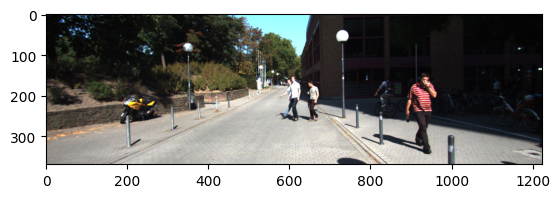

In [48]:
# Pre-processing and post-processing constants 
IMG_SCALE  = 1./255
IMG_MEAN = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
IMG_STD = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))

def prepare_img(img):
    return (img * IMG_SCALE - IMG_MEAN) / IMG_STD

CMAP = np.load('cmap_nyud.npy')
NUM_CLASSES = 40

images_files = glob.glob('data/*.png')
idx = np.random.randint(0, len(images_files))

img_path = images_files[idx]
img = np.array(Image.open(img_path))
plt.imshow(img)
plt.show()

Get and display the model's output for that image.

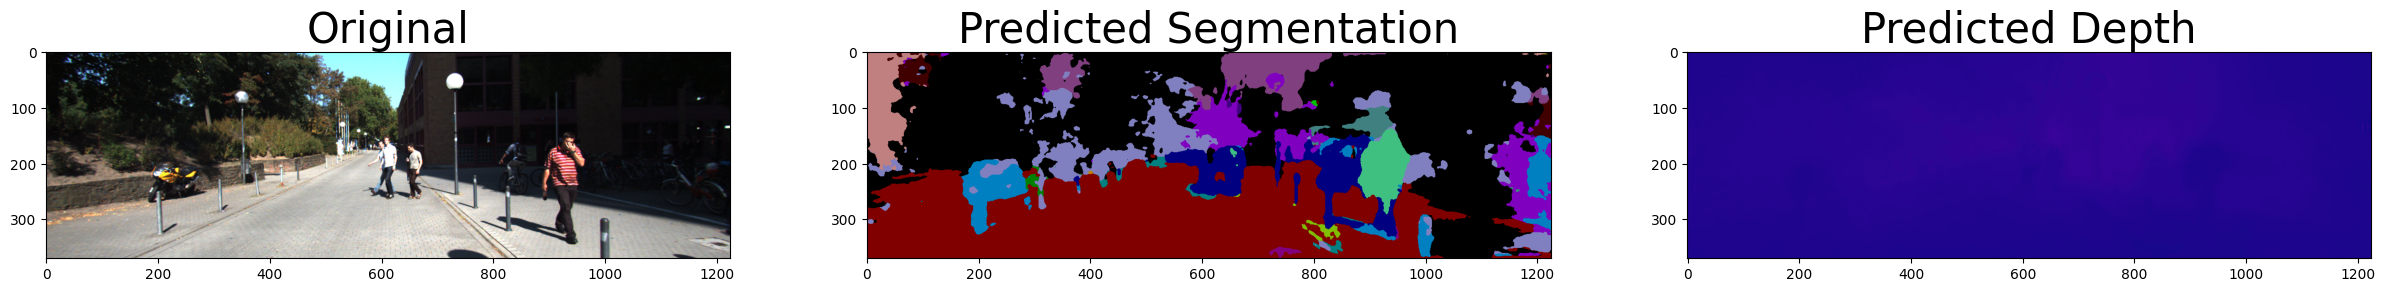

In [49]:
def pipeline(img):
    with torch.no_grad():
        img_var = Variable(torch.from_numpy(prepare_img(img).transpose(2, 0, 1)[None]), requires_grad=False).float()
        if torch.cuda.is_available():
            img_var = img_var.cuda()
        segm, depth = model(img_var)
        segm = cv2.resize(segm[0, :NUM_CLASSES].cpu().data.numpy().transpose(1, 2, 0),
                        img.shape[:2][::-1],
                        interpolation=cv2.INTER_CUBIC)
        depth = cv2.resize(depth[0, 0].cpu().data.numpy(),
                        img.shape[:2][::-1],
                        interpolation=cv2.INTER_CUBIC)
        segm = CMAP[segm.argmax(axis=2)].astype(np.uint8)
        depth = np.abs(depth)
        return depth, segm
    
depth, segm = pipeline(img)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,20))
ax1.imshow(img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(segm)
ax2.set_title('Predicted Segmentation', fontsize=30)
ax3.imshow(depth, cmap="plasma", vmin=0, vmax=80)
ax3.set_title("Predicted Depth", fontsize=30)
plt.show()

Let's normalize the depth and visualize it.

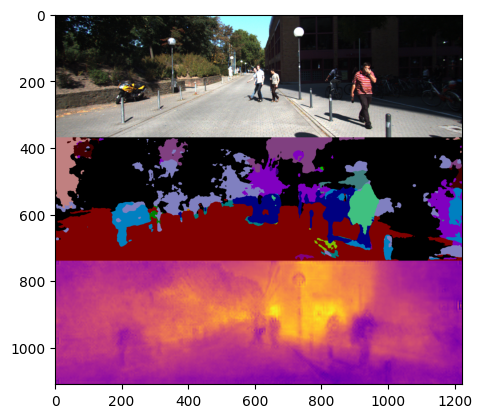

In [50]:
def depth_to_rgb(depth):
    normalizer = co.Normalize()
    mapper = cm.ScalarMappable(norm=normalizer, cmap='plasma')
    colormapped_im = (mapper.to_rgba(depth)[:, :, :3] * 255).astype(np.uint8)
    return colormapped_im

depth_rgb = depth_to_rgb(depth)

new_img = np.vstack((img, segm, depth_rgb))
plt.imshow(new_img)
plt.show()

Let's see how it looks as a video.

In [51]:
video_files = sorted(glob.glob("data/*.png"))

# Set the Model to Eval on GPU
if torch.cuda.is_available():
    _ = model.cuda()
_ = model.eval()

# Run the pipeline
result_video = []
for idx, img_path in enumerate(video_files):
    image = np.array(Image.open(img_path))
    h, w, _ = image.shape 
    depth, seg = pipeline(image)
    result_video.append(cv2.cvtColor(cv2.vconcat([image, seg, depth_to_rgb(depth)]), cv2.COLOR_BGR2RGB))

if not os.path.exists('output'):
    os.makedirs('output')

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output/out.mp4', fourcc, 15, (w,3*h))

for i in range(len(result_video)):
    out.write(result_video[i])
out.release()

# Extend the Model
There are many ways to transfer weights from one model to another, this approach uses composition to get backbone output from the base model to use it as input to an additional head. The base model is constructed in the same way however the parameter *return_backbone* is now set to true. This model is loaded with weights from the checkpoint and they are frozen to prevent changes that would affect the heads on the base model which also allows us to use larger batch sizes and ultimately train faster. Next the architecture of the new head is defined and the forward method shows how the backbone output is taken from the base model and passed to the new head. In order to minimize the additional complexities the new head is trained on the existing depth data however it allows us to experiment with different loss functions and optimizers than those used to train the base model.

In [52]:
ckpt_dir = "./extended_model"
ckpt_path = "checkpoint.pth.tar"

saver = Saver(
    #args=locals(), # Causes issues in vscode
    args={"items": None},
    ckpt_dir=ckpt_dir,
    best_val=init_vals,
    condition=comp_fns,
    save_several_mode=all,
)

num_classes = (40, 1)
backbone_path = "./base_model/checkpoint.pth.tar"

class Extended_Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Create an instance of the base model and load the saved weights
        encoder = MobileNetv2()
        decoder = MTLWRefineNet(encoder._out_c, num_classes, return_backbone=True)        
        self.net1 = nn.DataParallel(nn.Sequential(encoder, decoder))
        self.net1.load_state_dict(torch.load(backbone_path)['state_dict'])

        # Freeze the trained weights
        for param in self.net1.parameters():
            param.requires_grad = False

        conv1 = nn.Conv2d(256,128,1,1)
        conv2 = nn.Conv2d(128,64,3,1)
        conv3 = nn.Conv2d(64,1,3,1)
        self.net2 = nn.DataParallel(nn.Sequential(conv1, nn.ReLU6(inplace=True), conv2, nn.ReLU6(inplace=True), conv3, nn.ReLU6(inplace=True)))

    def forward(self, x):
        out = self.net1(x)
        y   = self.net2(out[-1])
        return out, y
    

hydranet = nn.DataParallel(Extended_Model()).to(device)

print("Model has {} parameters".format(sum([p.numel() for p in hydranet.parameters()])))

start_epoch, _, state_dict = saver.maybe_load(ckpt_path=ckpt_path, keys_to_load=["epoch", "best_val", "state_dict"],)
load_state_dict(hydranet, state_dict)

Model has 3177322 parameters


The display pipeline is modified to process the new head.

In [53]:
def pipeline(img):
    with torch.no_grad():
        img_var = Variable(torch.from_numpy(prepare_img(img).transpose(2, 0, 1)[None]), requires_grad=False).float()
        if torch.cuda.is_available():
            img_var = img_var.cuda()
        head1, depth2 = hydranet(img_var)    # The new forward method returns the old heads with the backbone outputs 
        segm, depth1 = head1[0], head1[1]    # and the new depth output, pull off what needs to be processed
        segm = cv2.resize(segm[0, :NUM_CLASSES].cpu().data.numpy().transpose(1, 2, 0),
                        img.shape[:2][::-1],
                        interpolation=cv2.INTER_CUBIC)
        depth1 = cv2.resize(depth1[0, 0].cpu().data.numpy(),
                        img.shape[:2][::-1],
                        interpolation=cv2.INTER_CUBIC)
        depth2 = cv2.resize(depth2[0, 0].cpu().data.numpy(),
                        img.shape[:2][::-1],
                        interpolation=cv2.INTER_CUBIC)
        segm = CMAP[segm.argmax(axis=2)].astype(np.uint8)
        depth1 = np.abs(depth1)
        depth2 = np.abs(depth2)
        return depth1, depth2, segm

Display the output before training.

(370, 1224)
(370, 1224)
(370, 1224, 3)


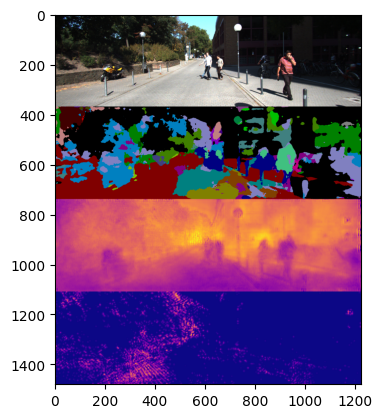

In [54]:
depth1, depth2, segm = pipeline(img)

print(depth1.shape)
print(depth2.shape)
print(segm.shape)

depth1_rgb = depth_to_rgb(depth1)
depth2_rgb = depth_to_rgb(depth2)

untrained_img = np.vstack((img, segm, depth1_rgb, depth2_rgb))
plt.imshow(untrained_img)
plt.show()

In [55]:
video_files = sorted(glob.glob("data/*.png"))

# Set the Model to Eval on GPU
if torch.cuda.is_available():
    _ = hydranet.cuda()
_ = hydranet.eval()


# Run the pipeline
result_video = []
for idx, img_path in enumerate(video_files):
    image = np.array(Image.open(img_path))
    h, w, _ = image.shape 
    depth1, depth2, seg = pipeline(image)
    result_video.append(cv2.cvtColor(cv2.vconcat([image, seg, depth_to_rgb(depth1), depth_to_rgb(depth2)]), cv2.COLOR_BGR2RGB))

if not os.path.exists('output'):
    os.makedirs('output')

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output/out2.mp4', fourcc, 15, (w,4*h))

for i in range(len(result_video)):
    out.write(result_video[i])
out.release()

# Train Extended Model
The train and validate methods have been modified to work with the new output structure of the forward method and to calculate the metrics based on the new depth head.

In [56]:
init_vals = (0.0, 10000.0)
comp_fns = [operator.gt, operator.lt]
ckpt_dir = "./extended_model"
ckpt_path = "./extended/checkpoint.pth.tar"

saver = Saver(
    #args=locals(),
    args={"items": None},
    ckpt_dir=ckpt_dir,
    best_val=init_vals,
    condition=comp_fns,
    save_several_mode=all,
)

n_epochs = 200

hydranet = nn.DataParallel(Extended_Model())

print("Model has {} parameters".format(sum([p.numel() for p in hydranet.parameters()])))

start_epoch, _, state_dict = saver.maybe_load(ckpt_path=ckpt_path, keys_to_load=["epoch", "best_val", "state_dict"],)
load_state_dict(hydranet, state_dict)

if start_epoch is None:
    start_epoch = 0

def train(model, opts, crits, dataloader, loss_coeffs=(1.0,), grad_norm=0.0):
    model.train()

    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
    loss_meter = AverageMeter()
    pbar = tqdm(dataloader)

    for sample in pbar:
        loss = 0.0
        input = sample["image"].float().to(device)
        targets = [sample[k].to(device) for k in dataloader.dataset.masks_names]
        outputs = model(input)

        loss = crits[0](
                F.interpolate(
                    outputs[-1], size=targets[-1].size()[1:], mode="bilinear", align_corners=False
                ).squeeze(dim=1),
                targets[-1].squeeze(dim=1),
            )
        
        opts[0].zero_grad()
        loss.backward()
        if grad_norm > 0.0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm)
        opts[0].step()

        loss_meter.update(loss.item())
        pbar.set_description(
            "Loss {:.3f} | Avg. Loss {:.3f}".format(loss.item(), loss_meter.avg)
        )

def validate(model, metrics, dataloader):
    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
    model.eval()
    for metric in metrics:
        metric.reset()

    pbar = tqdm(dataloader)

    def get_val(metrics):
        results = [(m.name, m.val()) for m in metrics]
        names, vals = list(zip(*results))
        out = ["{} : {:4f}".format(name, val) for name, val in results]
        return vals, " | ".join(out)

    with torch.no_grad():
        for sample in pbar:
            # Get the Data
            input = sample["image"].float().to(device)
            targets = [sample[k].to(device) for k in dataloader.dataset.masks_names]

            targets = [target.squeeze(dim=1).cpu().numpy() for target in targets]

            # Forward
            outputs, depth2 = model(input)
            outputs.pop(-1)                 # Remove the backbone from the outputs
            outputs[1] = depth2             # Use the new depth head for metric calculation

            # Backward
            for out, target, metric in zip(outputs, targets, metrics):
                metric.update(
                    F.interpolate(out, size=target.shape[1:], mode="bilinear", align_corners=False)
                    .squeeze(dim=1)
                    .cpu()
                    .numpy(),
                    target,
                )
            pbar.set_description(get_val(metrics)[1])
    vals, _ = get_val(metrics)
    print("----" * 5)
    return vals

Model has 3177322 parameters


In [57]:
print(start_epoch)
batch_size = 16
val_batch_size = 16
val_every = 5

# Try a different optimizer and loss function
optims = [torch.optim.Adam(hydranet.module.net2.parameters(), lr=lr_decoder)]
crit_depth = nn.MSELoss()

opt_scheds = []
for opt in optims:
    opt_scheds.append(torch.optim.lr_scheduler.MultiStepLR(opt, np.arange(start_epoch + 1, n_epochs, 100), gamma=0.1))
          
for i in range(start_epoch, n_epochs + 1):
    
    print("Epoch {:d}".format(i))
    train(hydranet, optims, [crit_depth], trainloader, loss_coeffs)

    for sched in opt_scheds:
        sched.step()
    
    if i % val_every == 0:
        metrics = [MeanIoU(num_classes[0]),RMSE(ignore_val=ignore_depth),]

        with torch.no_grad():
            vals = validate(hydranet, metrics, valloader)
        saver.maybe_save(new_val=vals, dict_to_save={"state_dict": hydranet.state_dict(), "epoch": i})

0
Epoch 0


Loss 1.389 | Avg. Loss 3.087: 100%|██████████| 198/198 [00:08<00:00, 24.58it/s]
meaniou : 0.269422 | rmse : 1.134435: 100%|██████████| 164/164 [01:49<00:00,  1.50it/s]


--------------------
Epoch 1


Loss 0.460 | Avg. Loss 1.714: 100%|██████████| 198/198 [00:08<00:00, 24.62it/s]


Epoch 2


Loss 2.852 | Avg. Loss 1.648: 100%|██████████| 198/198 [00:08<00:00, 24.42it/s]


Epoch 3


Loss 1.086 | Avg. Loss 1.701: 100%|██████████| 198/198 [00:08<00:00, 24.54it/s]


Epoch 4


Loss 2.262 | Avg. Loss 1.916: 100%|██████████| 198/198 [00:08<00:00, 24.55it/s]


Epoch 5


Loss 1.452 | Avg. Loss 1.854: 100%|██████████| 198/198 [00:08<00:00, 24.44it/s]
meaniou : 0.268715 | rmse : 0.981701: 100%|██████████| 164/164 [01:47<00:00,  1.52it/s]


--------------------
Epoch 6


Loss 0.402 | Avg. Loss 1.871: 100%|██████████| 198/198 [00:08<00:00, 24.65it/s]


Epoch 7


Loss 1.397 | Avg. Loss 1.759: 100%|██████████| 198/198 [00:08<00:00, 24.47it/s]


Epoch 8


Loss 2.142 | Avg. Loss 1.985: 100%|██████████| 198/198 [00:08<00:00, 24.53it/s]


Epoch 9


Loss 1.556 | Avg. Loss 1.746: 100%|██████████| 198/198 [00:08<00:00, 24.58it/s]


Epoch 10


Loss 0.846 | Avg. Loss 1.853: 100%|██████████| 198/198 [00:08<00:00, 24.45it/s]
meaniou : 0.267381 | rmse : 0.937207: 100%|██████████| 164/164 [01:47<00:00,  1.52it/s]


--------------------
Epoch 11


Loss 3.102 | Avg. Loss 1.815: 100%|██████████| 198/198 [00:08<00:00, 24.69it/s]


Epoch 12


Loss 1.787 | Avg. Loss 1.833: 100%|██████████| 198/198 [00:08<00:00, 24.63it/s]


Epoch 13


Loss 0.572 | Avg. Loss 1.599: 100%|██████████| 198/198 [00:08<00:00, 24.57it/s]


Epoch 14


Loss 1.320 | Avg. Loss 1.880: 100%|██████████| 198/198 [00:08<00:00, 24.54it/s]


Epoch 15


Loss 0.446 | Avg. Loss 1.787: 100%|██████████| 198/198 [00:08<00:00, 24.53it/s]
meaniou : 0.268724 | rmse : 1.030086: 100%|██████████| 164/164 [01:49<00:00,  1.50it/s]


--------------------
Epoch 16


Loss 0.977 | Avg. Loss 1.735: 100%|██████████| 198/198 [00:08<00:00, 24.72it/s]


Epoch 17


Loss 2.452 | Avg. Loss 1.744: 100%|██████████| 198/198 [00:08<00:00, 24.58it/s]


Epoch 18


Loss 1.808 | Avg. Loss 1.639: 100%|██████████| 198/198 [00:08<00:00, 24.71it/s]


Epoch 19


Loss 2.978 | Avg. Loss 1.879: 100%|██████████| 198/198 [00:08<00:00, 24.51it/s]


Epoch 20


Loss 0.700 | Avg. Loss 1.617: 100%|██████████| 198/198 [00:08<00:00, 24.68it/s]
meaniou : 0.268598 | rmse : 0.967217: 100%|██████████| 164/164 [01:47<00:00,  1.52it/s]


--------------------
Epoch 21


Loss 3.564 | Avg. Loss 1.763: 100%|██████████| 198/198 [00:08<00:00, 24.56it/s]


Epoch 22


Loss 0.835 | Avg. Loss 1.796: 100%|██████████| 198/198 [00:08<00:00, 24.68it/s]


Epoch 23


Loss 1.064 | Avg. Loss 1.678: 100%|██████████| 198/198 [00:08<00:00, 24.45it/s]


Epoch 24


Loss 2.973 | Avg. Loss 1.751: 100%|██████████| 198/198 [00:08<00:00, 24.55it/s]


Epoch 25


Loss 2.005 | Avg. Loss 1.762: 100%|██████████| 198/198 [00:08<00:00, 24.60it/s]
meaniou : 0.269587 | rmse : 0.905784: 100%|██████████| 164/164 [01:48<00:00,  1.52it/s]


--------------------
Epoch 26


Loss 0.824 | Avg. Loss 1.663: 100%|██████████| 198/198 [00:08<00:00, 24.74it/s]


Epoch 27


Loss 1.954 | Avg. Loss 1.751: 100%|██████████| 198/198 [00:08<00:00, 24.73it/s]


Epoch 28


Loss 2.607 | Avg. Loss 1.753: 100%|██████████| 198/198 [00:08<00:00, 24.62it/s]


Epoch 29


Loss 1.107 | Avg. Loss 1.650: 100%|██████████| 198/198 [00:08<00:00, 24.61it/s]


Epoch 30


Loss 1.712 | Avg. Loss 1.671: 100%|██████████| 198/198 [00:08<00:00, 24.58it/s]
meaniou : 0.265597 | rmse : 0.958018: 100%|██████████| 164/164 [01:47<00:00,  1.52it/s]


--------------------
Epoch 31


Loss 3.258 | Avg. Loss 1.730: 100%|██████████| 198/198 [00:08<00:00, 24.65it/s]


Epoch 32


Loss 3.002 | Avg. Loss 1.768: 100%|██████████| 198/198 [00:08<00:00, 24.63it/s]


Epoch 33


Loss 1.334 | Avg. Loss 1.811: 100%|██████████| 198/198 [00:08<00:00, 24.63it/s]


Epoch 34


Loss 2.614 | Avg. Loss 1.655: 100%|██████████| 198/198 [00:08<00:00, 24.53it/s]


Epoch 35


Loss 0.740 | Avg. Loss 1.751: 100%|██████████| 198/198 [00:08<00:00, 24.67it/s]
meaniou : 0.269151 | rmse : 0.946271: 100%|██████████| 164/164 [01:47<00:00,  1.52it/s]


--------------------
Epoch 36


Loss 1.031 | Avg. Loss 1.694: 100%|██████████| 198/198 [00:08<00:00, 24.53it/s]


Epoch 37


Loss 1.086 | Avg. Loss 1.643: 100%|██████████| 198/198 [00:08<00:00, 24.58it/s]


Epoch 38


Loss 1.842 | Avg. Loss 1.915: 100%|██████████| 198/198 [00:08<00:00, 24.59it/s]


Epoch 39


Loss 0.364 | Avg. Loss 1.487: 100%|██████████| 198/198 [00:08<00:00, 24.45it/s]


Epoch 40


Loss 1.725 | Avg. Loss 1.686: 100%|██████████| 198/198 [00:08<00:00, 24.59it/s]
meaniou : 0.270011 | rmse : 0.928405: 100%|██████████| 164/164 [01:47<00:00,  1.52it/s]


--------------------
Epoch 41


Loss 1.369 | Avg. Loss 1.597: 100%|██████████| 198/198 [00:08<00:00, 24.53it/s]


Epoch 42


Loss 0.680 | Avg. Loss 1.593: 100%|██████████| 198/198 [00:07<00:00, 24.78it/s]


Epoch 43


Loss 1.455 | Avg. Loss 1.742: 100%|██████████| 198/198 [00:08<00:00, 24.58it/s]


Epoch 44


Loss 2.317 | Avg. Loss 1.609: 100%|██████████| 198/198 [00:08<00:00, 24.48it/s]


Epoch 45


Loss 1.547 | Avg. Loss 1.734: 100%|██████████| 198/198 [00:08<00:00, 24.61it/s]
meaniou : 0.270878 | rmse : 0.965616: 100%|██████████| 164/164 [01:49<00:00,  1.50it/s]


--------------------
Epoch 46


Loss 3.982 | Avg. Loss 1.808: 100%|██████████| 198/198 [00:08<00:00, 24.67it/s]


Epoch 47


Loss 1.843 | Avg. Loss 1.716: 100%|██████████| 198/198 [00:08<00:00, 24.59it/s]


Epoch 48


Loss 0.741 | Avg. Loss 1.871: 100%|██████████| 198/198 [00:08<00:00, 24.51it/s]


Epoch 49


Loss 1.858 | Avg. Loss 1.802: 100%|██████████| 198/198 [00:08<00:00, 24.61it/s]


Epoch 50


Loss 1.398 | Avg. Loss 1.496: 100%|██████████| 198/198 [00:08<00:00, 24.70it/s]
meaniou : 0.272153 | rmse : 0.960534: 100%|██████████| 164/164 [01:49<00:00,  1.50it/s]


--------------------
Epoch 51


Loss 1.053 | Avg. Loss 1.619: 100%|██████████| 198/198 [00:08<00:00, 24.74it/s]


Epoch 52


Loss 1.113 | Avg. Loss 1.948: 100%|██████████| 198/198 [00:08<00:00, 24.74it/s]


Epoch 53


Loss 0.937 | Avg. Loss 1.663: 100%|██████████| 198/198 [00:08<00:00, 24.71it/s]


Epoch 54


Loss 0.996 | Avg. Loss 1.441: 100%|██████████| 198/198 [00:08<00:00, 24.63it/s]


Epoch 55


Loss 1.469 | Avg. Loss 1.600: 100%|██████████| 198/198 [00:07<00:00, 24.78it/s]
meaniou : 0.269080 | rmse : 0.957743: 100%|██████████| 164/164 [01:48<00:00,  1.51it/s]


--------------------
Epoch 56


Loss 1.616 | Avg. Loss 1.907: 100%|██████████| 198/198 [00:08<00:00, 24.69it/s]


Epoch 57


Loss 1.805 | Avg. Loss 1.605: 100%|██████████| 198/198 [00:08<00:00, 24.66it/s]


Epoch 58


Loss 1.111 | Avg. Loss 1.722: 100%|██████████| 198/198 [00:08<00:00, 24.52it/s]


Epoch 59


Loss 3.364 | Avg. Loss 1.676: 100%|██████████| 198/198 [00:08<00:00, 24.55it/s]


Epoch 60


Loss 2.491 | Avg. Loss 1.579: 100%|██████████| 198/198 [00:08<00:00, 24.50it/s]
meaniou : 0.267932 | rmse : 0.917247: 100%|██████████| 164/164 [01:48<00:00,  1.51it/s]


--------------------
Epoch 61


Loss 0.919 | Avg. Loss 1.719: 100%|██████████| 198/198 [00:08<00:00, 24.65it/s]


Epoch 62


Loss 1.150 | Avg. Loss 1.574: 100%|██████████| 198/198 [00:08<00:00, 24.62it/s]


Epoch 63


Loss 0.747 | Avg. Loss 1.765: 100%|██████████| 198/198 [00:08<00:00, 24.65it/s]


Epoch 64


Loss 0.840 | Avg. Loss 1.909: 100%|██████████| 198/198 [00:08<00:00, 24.63it/s]


Epoch 65


Loss 1.320 | Avg. Loss 1.485: 100%|██████████| 198/198 [00:08<00:00, 24.62it/s]
meaniou : 0.268123 | rmse : 0.934775: 100%|██████████| 164/164 [01:48<00:00,  1.51it/s]


--------------------
Epoch 66


Loss 1.755 | Avg. Loss 1.588: 100%|██████████| 198/198 [00:08<00:00, 24.63it/s]


Epoch 67


Loss 0.896 | Avg. Loss 1.598: 100%|██████████| 198/198 [00:08<00:00, 24.66it/s]


Epoch 68


Loss 1.186 | Avg. Loss 1.782: 100%|██████████| 198/198 [00:08<00:00, 24.48it/s]


Epoch 69


Loss 0.766 | Avg. Loss 1.719: 100%|██████████| 198/198 [00:08<00:00, 24.59it/s]


Epoch 70


Loss 1.063 | Avg. Loss 1.852: 100%|██████████| 198/198 [00:08<00:00, 24.48it/s]
meaniou : 0.270161 | rmse : 0.979372: 100%|██████████| 164/164 [01:49<00:00,  1.50it/s]


--------------------
Epoch 71


Loss 2.176 | Avg. Loss 1.754: 100%|██████████| 198/198 [00:08<00:00, 24.69it/s]


Epoch 72


Loss 1.518 | Avg. Loss 1.580: 100%|██████████| 198/198 [00:08<00:00, 24.62it/s]


Epoch 73


Loss 2.141 | Avg. Loss 1.678: 100%|██████████| 198/198 [00:08<00:00, 24.57it/s]


Epoch 74


Loss 1.567 | Avg. Loss 1.760: 100%|██████████| 198/198 [00:08<00:00, 24.56it/s]


Epoch 75


Loss 1.370 | Avg. Loss 1.749: 100%|██████████| 198/198 [00:08<00:00, 24.59it/s]
meaniou : 0.269808 | rmse : 0.964445: 100%|██████████| 164/164 [01:51<00:00,  1.48it/s]


--------------------
Epoch 76


Loss 0.690 | Avg. Loss 1.662: 100%|██████████| 198/198 [00:08<00:00, 24.70it/s]


Epoch 77


Loss 1.964 | Avg. Loss 1.696: 100%|██████████| 198/198 [00:08<00:00, 24.58it/s]


Epoch 78


Loss 1.691 | Avg. Loss 1.692: 100%|██████████| 198/198 [00:08<00:00, 24.58it/s]


Epoch 79


Loss 1.968 | Avg. Loss 1.507: 100%|██████████| 198/198 [00:08<00:00, 24.53it/s]


Epoch 80


Loss 1.030 | Avg. Loss 1.551: 100%|██████████| 198/198 [00:08<00:00, 24.52it/s]
meaniou : 0.269147 | rmse : 0.921111: 100%|██████████| 164/164 [01:52<00:00,  1.46it/s]


--------------------
Epoch 81


Loss 1.244 | Avg. Loss 1.498: 100%|██████████| 198/198 [00:08<00:00, 24.72it/s]


Epoch 82


Loss 0.766 | Avg. Loss 1.640: 100%|██████████| 198/198 [00:08<00:00, 24.59it/s]


Epoch 83


Loss 1.032 | Avg. Loss 1.589: 100%|██████████| 198/198 [00:08<00:00, 24.48it/s]


Epoch 84


Loss 1.940 | Avg. Loss 1.601: 100%|██████████| 198/198 [00:08<00:00, 24.56it/s]


Epoch 85


Loss 1.145 | Avg. Loss 1.665: 100%|██████████| 198/198 [00:08<00:00, 24.54it/s]
meaniou : 0.270596 | rmse : 0.906564: 100%|██████████| 164/164 [01:51<00:00,  1.47it/s]


--------------------
Epoch 86


Loss 1.441 | Avg. Loss 1.838: 100%|██████████| 198/198 [00:08<00:00, 24.66it/s]


Epoch 87


Loss 3.017 | Avg. Loss 1.546: 100%|██████████| 198/198 [00:08<00:00, 24.47it/s]


Epoch 88


Loss 1.777 | Avg. Loss 1.639: 100%|██████████| 198/198 [00:08<00:00, 24.53it/s]


Epoch 89


Loss 1.929 | Avg. Loss 1.694: 100%|██████████| 198/198 [00:08<00:00, 24.52it/s]


Epoch 90


Loss 1.630 | Avg. Loss 1.569: 100%|██████████| 198/198 [00:08<00:00, 24.56it/s]
meaniou : 0.269420 | rmse : 0.994418: 100%|██████████| 164/164 [01:51<00:00,  1.47it/s]


--------------------
Epoch 91


Loss 2.136 | Avg. Loss 1.509: 100%|██████████| 198/198 [00:08<00:00, 24.71it/s]


Epoch 92


Loss 1.540 | Avg. Loss 1.703: 100%|██████████| 198/198 [00:08<00:00, 24.57it/s]


Epoch 93


Loss 2.519 | Avg. Loss 1.705: 100%|██████████| 198/198 [00:08<00:00, 24.75it/s]


Epoch 94


Loss 1.094 | Avg. Loss 1.644: 100%|██████████| 198/198 [00:08<00:00, 24.59it/s]


Epoch 95


Loss 1.508 | Avg. Loss 1.566: 100%|██████████| 198/198 [00:08<00:00, 24.55it/s]
meaniou : 0.271085 | rmse : 0.983020: 100%|██████████| 164/164 [01:51<00:00,  1.47it/s]


--------------------
Epoch 96


Loss 0.341 | Avg. Loss 1.776: 100%|██████████| 198/198 [00:08<00:00, 24.69it/s]


Epoch 97


Loss 1.999 | Avg. Loss 1.540: 100%|██████████| 198/198 [00:08<00:00, 24.66it/s]


Epoch 98


Loss 0.621 | Avg. Loss 1.522: 100%|██████████| 198/198 [00:08<00:00, 24.65it/s]


Epoch 99


Loss 1.954 | Avg. Loss 1.494: 100%|██████████| 198/198 [00:08<00:00, 24.59it/s]


Epoch 100


Loss 0.542 | Avg. Loss 1.765: 100%|██████████| 198/198 [00:08<00:00, 24.58it/s]
meaniou : 0.273080 | rmse : 0.937786: 100%|██████████| 164/164 [01:52<00:00,  1.46it/s]


--------------------
Epoch 101


Loss 1.458 | Avg. Loss 1.862: 100%|██████████| 198/198 [00:08<00:00, 24.69it/s]


Epoch 102


Loss 2.179 | Avg. Loss 1.553: 100%|██████████| 198/198 [00:08<00:00, 24.48it/s]


Epoch 103


Loss 0.746 | Avg. Loss 1.530: 100%|██████████| 198/198 [00:08<00:00, 24.61it/s]


Epoch 104


Loss 0.773 | Avg. Loss 1.414: 100%|██████████| 198/198 [00:08<00:00, 24.52it/s]


Epoch 105


Loss 1.495 | Avg. Loss 1.384: 100%|██████████| 198/198 [00:08<00:00, 24.59it/s]
meaniou : 0.270114 | rmse : 0.954580: 100%|██████████| 164/164 [01:51<00:00,  1.47it/s]


--------------------
Epoch 106


Loss 1.493 | Avg. Loss 1.699: 100%|██████████| 198/198 [00:08<00:00, 24.69it/s]


Epoch 107


Loss 0.823 | Avg. Loss 1.521: 100%|██████████| 198/198 [00:08<00:00, 24.52it/s]


Epoch 108


Loss 0.910 | Avg. Loss 1.673: 100%|██████████| 198/198 [00:08<00:00, 24.64it/s]


Epoch 109


Loss 0.847 | Avg. Loss 1.507: 100%|██████████| 198/198 [00:08<00:00, 24.49it/s]


Epoch 110


Loss 1.289 | Avg. Loss 1.570: 100%|██████████| 198/198 [00:08<00:00, 24.56it/s]
meaniou : 0.270979 | rmse : 0.952437: 100%|██████████| 164/164 [01:51<00:00,  1.47it/s]


--------------------
Epoch 111


Loss 1.517 | Avg. Loss 1.502: 100%|██████████| 198/198 [00:08<00:00, 24.65it/s]


Epoch 112


Loss 1.827 | Avg. Loss 1.502: 100%|██████████| 198/198 [00:08<00:00, 24.66it/s]


Epoch 113


Loss 1.920 | Avg. Loss 1.564: 100%|██████████| 198/198 [00:08<00:00, 24.54it/s]


Epoch 114


Loss 1.049 | Avg. Loss 1.582: 100%|██████████| 198/198 [00:08<00:00, 24.48it/s]


Epoch 115


Loss 1.249 | Avg. Loss 1.575: 100%|██████████| 198/198 [00:08<00:00, 24.46it/s]
meaniou : 0.267462 | rmse : 0.962843: 100%|██████████| 164/164 [01:46<00:00,  1.53it/s]


--------------------
Epoch 116


Loss 0.614 | Avg. Loss 1.587: 100%|██████████| 198/198 [00:08<00:00, 24.70it/s]


Epoch 117


Loss 1.647 | Avg. Loss 1.624: 100%|██████████| 198/198 [00:08<00:00, 24.67it/s]


Epoch 118


Loss 2.605 | Avg. Loss 1.589: 100%|██████████| 198/198 [00:08<00:00, 24.68it/s]


Epoch 119


Loss 1.374 | Avg. Loss 1.557: 100%|██████████| 198/198 [00:08<00:00, 24.60it/s]


Epoch 120


Loss 1.467 | Avg. Loss 1.495: 100%|██████████| 198/198 [00:08<00:00, 24.64it/s]
meaniou : 0.269836 | rmse : 0.963611: 100%|██████████| 164/164 [01:47<00:00,  1.53it/s]


--------------------
Epoch 121


Loss 1.337 | Avg. Loss 1.476: 100%|██████████| 198/198 [00:08<00:00, 24.75it/s]


Epoch 122


Loss 1.433 | Avg. Loss 1.530: 100%|██████████| 198/198 [00:08<00:00, 24.70it/s]


Epoch 123


Loss 0.635 | Avg. Loss 1.552: 100%|██████████| 198/198 [00:08<00:00, 24.73it/s]


Epoch 124


Loss 1.678 | Avg. Loss 1.486: 100%|██████████| 198/198 [00:08<00:00, 24.57it/s]


Epoch 125


Loss 2.074 | Avg. Loss 1.503: 100%|██████████| 198/198 [00:08<00:00, 24.47it/s]
meaniou : 0.268609 | rmse : 0.958737: 100%|██████████| 164/164 [01:47<00:00,  1.52it/s]


--------------------
Epoch 126


Loss 1.589 | Avg. Loss 1.497: 100%|██████████| 198/198 [00:08<00:00, 24.67it/s]


Epoch 127


Loss 1.148 | Avg. Loss 1.521: 100%|██████████| 198/198 [00:07<00:00, 24.81it/s]


Epoch 128


Loss 1.193 | Avg. Loss 1.575: 100%|██████████| 198/198 [00:08<00:00, 24.62it/s]


Epoch 129


Loss 1.081 | Avg. Loss 1.701: 100%|██████████| 198/198 [00:08<00:00, 24.58it/s]


Epoch 130


Loss 0.841 | Avg. Loss 1.771: 100%|██████████| 198/198 [00:08<00:00, 24.67it/s]
meaniou : 0.268318 | rmse : 0.961954: 100%|██████████| 164/164 [01:46<00:00,  1.53it/s]


--------------------
Epoch 131


Loss 2.259 | Avg. Loss 1.489: 100%|██████████| 198/198 [00:08<00:00, 24.63it/s]


Epoch 132


Loss 1.257 | Avg. Loss 1.656: 100%|██████████| 198/198 [00:08<00:00, 24.62it/s]


Epoch 133


Loss 4.077 | Avg. Loss 1.493: 100%|██████████| 198/198 [00:08<00:00, 24.65it/s]


Epoch 134


Loss 2.371 | Avg. Loss 1.612: 100%|██████████| 198/198 [00:08<00:00, 24.59it/s]


Epoch 135


Loss 0.633 | Avg. Loss 1.545: 100%|██████████| 198/198 [00:08<00:00, 24.72it/s]
meaniou : 0.268986 | rmse : 0.963249: 100%|██████████| 164/164 [01:49<00:00,  1.50it/s]


--------------------
Epoch 136


Loss 2.786 | Avg. Loss 1.506: 100%|██████████| 198/198 [00:08<00:00, 24.53it/s]


Epoch 137


Loss 1.393 | Avg. Loss 1.443: 100%|██████████| 198/198 [00:08<00:00, 24.61it/s]


Epoch 138


Loss 1.385 | Avg. Loss 1.361: 100%|██████████| 198/198 [00:08<00:00, 24.57it/s]


Epoch 139


Loss 2.773 | Avg. Loss 1.660: 100%|██████████| 198/198 [00:08<00:00, 24.56it/s]


Epoch 140


Loss 0.677 | Avg. Loss 1.540: 100%|██████████| 198/198 [00:08<00:00, 24.64it/s]
meaniou : 0.272994 | rmse : 0.954265: 100%|██████████| 164/164 [01:47<00:00,  1.52it/s]


--------------------
Epoch 141


Loss 2.314 | Avg. Loss 1.758: 100%|██████████| 198/198 [00:08<00:00, 24.65it/s]


Epoch 142


Loss 1.024 | Avg. Loss 1.486: 100%|██████████| 198/198 [00:08<00:00, 24.68it/s]


Epoch 143


Loss 1.245 | Avg. Loss 1.476: 100%|██████████| 198/198 [00:08<00:00, 24.68it/s]


Epoch 144


Loss 0.717 | Avg. Loss 1.724: 100%|██████████| 198/198 [00:08<00:00, 24.63it/s]


Epoch 145


Loss 0.906 | Avg. Loss 1.578: 100%|██████████| 198/198 [00:08<00:00, 24.56it/s]
meaniou : 0.270639 | rmse : 0.959648: 100%|██████████| 164/164 [01:48<00:00,  1.51it/s]


--------------------
Epoch 146


Loss 0.898 | Avg. Loss 1.560: 100%|██████████| 198/198 [00:08<00:00, 24.68it/s]


Epoch 147


Loss 1.155 | Avg. Loss 1.608: 100%|██████████| 198/198 [00:08<00:00, 24.62it/s]


Epoch 148


Loss 1.890 | Avg. Loss 1.532: 100%|██████████| 198/198 [00:08<00:00, 24.54it/s]


Epoch 149


Loss 1.298 | Avg. Loss 1.915: 100%|██████████| 198/198 [00:08<00:00, 24.70it/s]


Epoch 150


Loss 1.624 | Avg. Loss 1.428: 100%|██████████| 198/198 [00:08<00:00, 24.51it/s]
meaniou : 0.270938 | rmse : 0.967923: 100%|██████████| 164/164 [01:48<00:00,  1.51it/s]


--------------------
Epoch 151


Loss 2.411 | Avg. Loss 1.470: 100%|██████████| 198/198 [00:08<00:00, 24.67it/s]


Epoch 152


Loss 0.997 | Avg. Loss 1.601: 100%|██████████| 198/198 [00:08<00:00, 24.59it/s]


Epoch 153


Loss 1.039 | Avg. Loss 1.549: 100%|██████████| 198/198 [00:08<00:00, 24.63it/s]


Epoch 154


Loss 0.874 | Avg. Loss 1.623: 100%|██████████| 198/198 [00:08<00:00, 24.53it/s]


Epoch 155


Loss 0.777 | Avg. Loss 1.576: 100%|██████████| 198/198 [00:08<00:00, 24.55it/s]
meaniou : 0.267920 | rmse : 0.966215: 100%|██████████| 164/164 [01:52<00:00,  1.46it/s]


--------------------
Epoch 156


Loss 2.585 | Avg. Loss 1.491: 100%|██████████| 198/198 [00:08<00:00, 24.60it/s]


Epoch 157


Loss 1.598 | Avg. Loss 1.538: 100%|██████████| 198/198 [00:08<00:00, 24.39it/s]


Epoch 158


Loss 0.656 | Avg. Loss 1.599: 100%|██████████| 198/198 [00:08<00:00, 24.38it/s]


Epoch 159


Loss 0.878 | Avg. Loss 1.446: 100%|██████████| 198/198 [00:08<00:00, 24.38it/s]


Epoch 160


Loss 3.008 | Avg. Loss 1.588: 100%|██████████| 198/198 [00:08<00:00, 24.34it/s]
meaniou : 0.265563 | rmse : 0.960077: 100%|██████████| 164/164 [01:53<00:00,  1.45it/s]


--------------------
Epoch 161


Loss 1.757 | Avg. Loss 1.517: 100%|██████████| 198/198 [00:08<00:00, 24.48it/s]


Epoch 162


Loss 1.789 | Avg. Loss 1.522: 100%|██████████| 198/198 [00:08<00:00, 24.45it/s]


Epoch 163


Loss 0.696 | Avg. Loss 1.463: 100%|██████████| 198/198 [00:08<00:00, 24.29it/s]


Epoch 164


Loss 1.165 | Avg. Loss 1.474: 100%|██████████| 198/198 [00:08<00:00, 24.42it/s]


Epoch 165


Loss 0.978 | Avg. Loss 1.582: 100%|██████████| 198/198 [00:08<00:00, 24.23it/s]
meaniou : 0.268395 | rmse : 0.960667: 100%|██████████| 164/164 [01:52<00:00,  1.45it/s]


--------------------
Epoch 166


Loss 1.121 | Avg. Loss 1.659: 100%|██████████| 198/198 [00:08<00:00, 24.49it/s]


Epoch 167


Loss 0.932 | Avg. Loss 1.413: 100%|██████████| 198/198 [00:08<00:00, 24.55it/s]


Epoch 168


Loss 2.447 | Avg. Loss 1.556: 100%|██████████| 198/198 [00:08<00:00, 24.45it/s]


Epoch 169


Loss 2.159 | Avg. Loss 1.592: 100%|██████████| 198/198 [00:08<00:00, 24.35it/s]


Epoch 170


Loss 3.355 | Avg. Loss 1.598: 100%|██████████| 198/198 [00:08<00:00, 24.52it/s]
meaniou : 0.269053 | rmse : 0.961241: 100%|██████████| 164/164 [01:52<00:00,  1.45it/s]


--------------------
Epoch 171


Loss 0.535 | Avg. Loss 1.684: 100%|██████████| 198/198 [00:08<00:00, 24.57it/s]


Epoch 172


Loss 2.091 | Avg. Loss 1.633: 100%|██████████| 198/198 [00:08<00:00, 24.43it/s]


Epoch 173


Loss 1.620 | Avg. Loss 1.552: 100%|██████████| 198/198 [00:08<00:00, 24.54it/s]


Epoch 174


Loss 1.878 | Avg. Loss 1.517: 100%|██████████| 198/198 [00:08<00:00, 24.49it/s]


Epoch 175


Loss 1.044 | Avg. Loss 1.528: 100%|██████████| 198/198 [00:08<00:00, 24.40it/s]
meaniou : 0.268747 | rmse : 0.958830: 100%|██████████| 164/164 [01:49<00:00,  1.50it/s]


--------------------
Epoch 176


Loss 0.717 | Avg. Loss 1.709: 100%|██████████| 198/198 [00:08<00:00, 24.66it/s]


Epoch 177


Loss 3.642 | Avg. Loss 1.658: 100%|██████████| 198/198 [00:08<00:00, 24.65it/s]


Epoch 178


Loss 2.768 | Avg. Loss 1.678: 100%|██████████| 198/198 [00:08<00:00, 24.62it/s]


Epoch 179


Loss 1.479 | Avg. Loss 1.527: 100%|██████████| 198/198 [00:08<00:00, 24.67it/s]


Epoch 180


Loss 3.267 | Avg. Loss 1.582: 100%|██████████| 198/198 [00:08<00:00, 24.49it/s]
meaniou : 0.270603 | rmse : 0.966634: 100%|██████████| 164/164 [01:49<00:00,  1.49it/s]


--------------------
Epoch 181


Loss 1.295 | Avg. Loss 1.520: 100%|██████████| 198/198 [00:08<00:00, 24.65it/s]


Epoch 182


Loss 2.956 | Avg. Loss 1.497: 100%|██████████| 198/198 [00:07<00:00, 24.78it/s]


Epoch 183


Loss 1.199 | Avg. Loss 1.584: 100%|██████████| 198/198 [00:08<00:00, 24.65it/s]


Epoch 184


Loss 4.163 | Avg. Loss 1.457: 100%|██████████| 198/198 [00:08<00:00, 24.63it/s]


Epoch 185


Loss 1.601 | Avg. Loss 1.650: 100%|██████████| 198/198 [00:08<00:00, 24.71it/s]
meaniou : 0.264851 | rmse : 0.973106: 100%|██████████| 164/164 [01:48<00:00,  1.51it/s]


--------------------
Epoch 186


Loss 0.719 | Avg. Loss 1.813: 100%|██████████| 198/198 [00:08<00:00, 24.70it/s]


Epoch 187


Loss 1.574 | Avg. Loss 1.565: 100%|██████████| 198/198 [00:08<00:00, 24.67it/s]


Epoch 188


Loss 2.411 | Avg. Loss 1.538: 100%|██████████| 198/198 [00:08<00:00, 24.65it/s]


Epoch 189


Loss 3.223 | Avg. Loss 1.607: 100%|██████████| 198/198 [00:08<00:00, 24.66it/s]


Epoch 190


Loss 1.668 | Avg. Loss 1.812: 100%|██████████| 198/198 [00:08<00:00, 24.52it/s]
meaniou : 0.269661 | rmse : 0.961264: 100%|██████████| 164/164 [01:49<00:00,  1.50it/s]


--------------------
Epoch 191


Loss 2.437 | Avg. Loss 1.509: 100%|██████████| 198/198 [00:08<00:00, 24.59it/s]


Epoch 192


Loss 2.893 | Avg. Loss 1.660: 100%|██████████| 198/198 [00:08<00:00, 24.72it/s]


Epoch 193


Loss 0.879 | Avg. Loss 1.731: 100%|██████████| 198/198 [00:08<00:00, 24.59it/s]


Epoch 194


Loss 0.533 | Avg. Loss 1.650: 100%|██████████| 198/198 [00:08<00:00, 24.69it/s]


Epoch 195


Loss 1.548 | Avg. Loss 1.462: 100%|██████████| 198/198 [00:08<00:00, 24.51it/s]
meaniou : 0.270075 | rmse : 0.955649: 100%|██████████| 164/164 [01:48<00:00,  1.51it/s]


--------------------
Epoch 196


Loss 2.740 | Avg. Loss 1.497: 100%|██████████| 198/198 [00:08<00:00, 24.63it/s]


Epoch 197


Loss 4.248 | Avg. Loss 1.525: 100%|██████████| 198/198 [00:08<00:00, 24.54it/s]


Epoch 198


Loss 0.799 | Avg. Loss 1.728: 100%|██████████| 198/198 [00:08<00:00, 24.51it/s]


Epoch 199


Loss 2.557 | Avg. Loss 1.593: 100%|██████████| 198/198 [00:08<00:00, 24.61it/s]


Epoch 200


Loss 1.005 | Avg. Loss 1.636: 100%|██████████| 198/198 [00:08<00:00, 24.62it/s]
meaniou : 0.267772 | rmse : 0.977319: 100%|██████████| 164/164 [01:49<00:00,  1.50it/s]

--------------------


# Visualize Results
Now that it's trained let's see if the output looks better. Notice that the output for the base model's heads are unchanged.

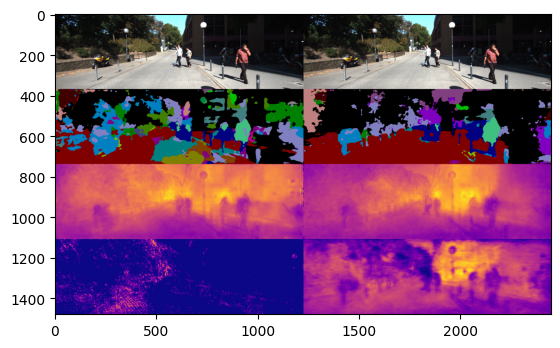

In [58]:
depth1, depth2, segm = pipeline(img)
depth1_rgb = depth_to_rgb(depth1)
depth2_rgb = depth_to_rgb(depth2)

new_img = np.hstack((untrained_img, np.vstack((img, segm, depth1_rgb, depth2_rgb))))
plt.imshow(new_img)
plt.show()

In [59]:
video_files = sorted(glob.glob("data/*.png"))

# Set the Model to Eval on GPU
if torch.cuda.is_available():
    _ = hydranet.cuda()
_ = hydranet.eval()


# Run the pipeline
result_video = []
for idx, img_path in enumerate(video_files):
    image = np.array(Image.open(img_path))
    h, w, _ = image.shape 
    depth1, depth2, seg = pipeline(image)
    result_video.append(cv2.cvtColor(cv2.vconcat([image, seg, depth_to_rgb(depth1), depth_to_rgb(depth2)]), cv2.COLOR_BGR2RGB))

if not os.path.exists('output'):
    os.makedirs('output')

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output/out3.mp4', fourcc, 15, (w,4*h))

for i in range(len(result_video)):
    out.write(result_video[i])
out.release()

<video width="800" controls>
    <source src="./output/out3.mp4" type="video/mp4">
</video>